In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [2]:
# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
logging.getLogger("qick_processor").setLevel(logging.WARNING)

In [3]:
from qick.drivers.peripherals import QICK_Time_Tagger
import time

class QickTTSoc(QickSoc):

    # Constructor.
    def __init__(self, bitfile, **kwargs):
        super().__init__(bitfile=bitfile, **kwargs)
        self.qtt = self.qick_time_tagger_0
        
        # add the time-tagger channels to the firmware description
        self['extra_description'].append("\n\tTime tagger channels:")
        for i, (_, adcdesc) in enumerate(self.qtt['adcs']):
            self['extra_description'].append("\t%d:\t%s" % (i, adcdesc) )
            
        # add the arm pin to the tproc pins list
        tproccfg = self['tprocs'][0]
        ((block, port),) = self.metadata.trace_sig('qick_time_tagger_0','arm_i')
        portnum, porttype = self.tproc.port2ch(port)
        tproccfg['output_pins'].append((porttype, portnum, 0, 'arm time tagger'))
            
    def tt_calibrate_adc(self, tt_ch):
        """Calibrate the selected time-tagger channel's ADC.
        Before calling this, you need to start playing a continuous low-frequency signal into that ADC.
        If you don't calibrate, you may see gain shifts between the 8 sub-ADCs, which will show up as period-8 wiggles in the sample data.
        """
        tile, block = [int(x) for x in self.qtt['adcs'][tt_ch][0]]
        self.rf.adc_tiles[tile].blocks[block].CalibrationMode=2 # optimized for [DC, 0.4*fs]
        self.rf.adc_tiles[tile].blocks[block].CalFreeze['FreezeCalibration']=0
        time.sleep(1)
        self.rf.adc_tiles[tile].blocks[block].CalFreeze['FreezeCalibration']=1

The current time-tagger demo firmware is for ZCU216:

https://s3df.slac.stanford.edu/people/meeg/qick/tprocv2/2025-02-23_216_tprocv2r21_qtt/

In [4]:
# soc = QickTTSoc('/data/fw/2025-02-13_216_tprocv2r21_qtt/qick_216.bit')
# soc = QickTTSoc('/data/fw/2025-02-22_216_tprocv2r21_qtt-debug/qick_216.bit')
soc = QickTTSoc('/data/fw/2025-02-23_216_tprocv2r21_qtt/qick_216.bit')

soccfg = soc
print(soccfg)

QICK running on ZCU216, software version 0.2.314

Firmware configuration (built Sun Feb 23 17:41:13 2025):

	Global clocks (MHz): tProcessor 307.200, RF reference 245.760

	4 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 32-bit DDS, range=4915.200 MHz
		DAC tile 3, blk 0 is 0_231, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 32-bit DDS, range=4915.200 MHz
		DAC tile 3, blk 2 is 2_231, on JHC3

	1 readout channels:
	0:	axis_dyn_readout_v1 - configured by tProc output 4
		fs=2457.600 MHz, deci

In [5]:
# additional info on the time-tagger config and state

# soc.qtt.info()
# soc.qtt.get_config(print_cfg = True)
# soc.qtt.print_axi_regs()
# soc.qtt.print_debug()

### This firmware
In this notebook we'll play identical pulses on two generators.
The first (on 0_230) will be connected to a regular QICK dynamic readout (on 0_226).
The second (on 2_230) will be connected to a time-tagger input (on 2_226).

For this demo I'm using low-frequency baluns.

In [6]:
# ID of the generator that's connected to regular readout
GEN_CH_REG = 2
# ID of the generator that's connected to the time tagger
GEN_CH_TT = 3
# ID of the regular readout that's connected to a generator
RO_CH = 0
# ID of the time-tagger channel that's connected to a generator
TT_CH = 0

### ADC calibration
The RF-ADCs work by running 8 sub-ADCs in parallel.
When looking at DC pulses, differences in the sub-ADC calibration will show up as period-8 ripples.
You can calibrate the ADC by playing a low-frequency RF tone and using tt_calibrate_adc().

In [7]:
class CalProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=1)
        self.add_pulse(ch=gen_ch, name="myconst",
                       style="const", 
                       length=1.0, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                       mode='periodic', # play repeatedly, forever
                      )

    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)
        
config = {'gen_ch': GEN_CH_TT,
          'freq': 100,
         }
calprog = CalProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

calprog.run(soc) # run the program, which will play a continuous calibration tone.
soc.tt_calibrate_adc(TT_CH) # calibrate the ADC for 1 second and freeze the ADC calibration
soc.reset_gens() # stop playing the calibration tone

### Configuring the time-tagger
minor observations:
* at least with default settings, if the pulse width exceeds the dead time the time-tagger will retrigger in the middle of the pulse
* if wr_smp is bigger than the dead time, the number of captures in the SMP memory will be smaller than the number of tags

In [8]:
NSAMP = 32 # units of ADC fabric clocks
soc.qtt.set_config(filt=0, slope=0, interp=0, wr_smp=NSAMP, invert=0)
soc.qtt.set_dead_time(20) # units of ADC fabric clocks
soc.qtt.set_threshold(2000) # units of ADU, as measured by time-tagger

### Reading the time-tagger
As the time-tagger captures tags, it fills some internal memories:
* TAG0-3: tags from each channel, in units of ADC sampling clocks
* SMP: raw ADC samples for each tag, channel 0 only
* ARM: number of tags per arming window, channel 0 only

Each memory has an associated counter that tells you how many values are currently stored.

Note that the memories are FIFO queues and values are popped (deleted) as you read them.

In [9]:
def plot_tags(nsamp):
    print("total tags:", soc.qtt.tag0_qty)
    print("tags per arming window:", soc.qtt.read_mem('ARM'))
    print("tags:", soc.qtt.read_mem('TAG0'))
    print("total samples:", soc.qtt.smp_qty)

    t = np.arange(nsamp*8)/(8*soc.qtt['f_fabric'])
    if soc.qtt.smp_qty>0:
        allsamps = soc.qtt.read_mem('SMP')
        for i, samps in enumerate(allsamps.reshape((-1, nsamp*8))):
            plt.plot(t, samps, label='tag %d'%(i))
        plt.legend()
        plt.ylabel("amplitude [ADU]")
        plt.xlabel("time [us]");

### Arming the time-tagger
You activate the time-tagger by "arming" it for some window of time.
It captures pulses during that time window and records tags relative to the arming time.

There are three ways to arm the time-tagger:
* with arm/disarm commands sent with Python methods before/after running your program (very slow, arming time is completely uncontrolled relative to start-of-program) - this is easy and may be appropriate if you just want to run the tagger for a while and look at what's coming in
* with arm/disarm commands sent from the tProc using its "peripheral" interface (clunky, arming time is not well controlled) - not very useful, included for completeness
* with a trigger pulse sent from the tProc - this is the preferred way to arm the tagger synchronously with the rest of a program

In [10]:
class ArmingProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch0 = cfg['gen_chs'][0]
        
        ramp_len = 0.1

        for gen_ch in cfg['gen_chs']:
            self.declare_gen(ch=gen_ch, nqz=1)
            self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        
        self.add_pulse(ch=cfg['gen_chs'], name="myflattop",
                       style="flat_top", 
                       envelope="ramp", 
                       freq=0, 
                       length=0.02,
                       phase=0,
                       gain=1.0, 
                      )
        self.add_pulse(ch=cfg['gen_chs'], name="mygaus",
                       style="arb", 
                       envelope="ramp", 
                       freq=0, 
                       phase=0,
                       gain=1.0, 
                      )
        self.add_pulse(ch=cfg['gen_chs'], name="myconst",
                       style="const", 
                       length=0.05,
                       freq=0, 
                       phase=0,
                       gain=1.0,
                      )
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=0)
        
        if cfg['arming']=='peripheral':
            # unlike pulses/triggers that can be pre-scheduled, peripheral commands don't go through a timed queue
            # so the time-tagger gets the command whenever this executes
            # to control when this happens, you need to use "wait"
            self.wait(0.5)
            self.asm_inst({'CMD': 'PA', 'C_OP': '1', 'R1': 's0'}) # arm
            # the R1 argument is not used (s0 is the zero register and is used here as a placeholder)
            # C_OP=0: disarm
            # C_OP=1: arm
            # C_OP=2: pop
            # C_OP=3: ???
            # C_OP=4: set threshold to R1[15:0]
            # C_OP=5: set deadtime to R1[7:0]
            # C_OP=6: ???
            # C_OP=7: reset

        self.delay(0.5)
        if cfg['arming']=='trigger':
            self.trigger(pins=[8], t=0, width=10.0) # make the arming window big enough to capture all the pulses

        # configure the regular readout
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)

    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        for gen_ch in cfg['gen_chs']:
            self.pulse(ch=gen_ch, name="myconst", t=0)
            self.pulse(ch=gen_ch, name="myflattop", t=0.2)
            self.pulse(ch=gen_ch, name="mygaus", t=0.4)
            
    def _cleanup(self, cfg):
        if cfg['arming']=='peripheral':
            self.asm_inst({'CMD': 'PA', 'C_OP': '0', 'R1': 's0'}) # disarm
            # the R1 argument is not used (s0 is the zero register and is used here as a placeholder)

config = {'gen_chs': [GEN_CH_TT, GEN_CH_REG],
          'ro_ch': RO_CH,
          'ro_len': 0.8, # readout window for the regular readout
          'trig_time': 0.4, # trigger time for the regular readout
          'arming': 'none', # how to arm the time-tagger
         }

  0%|          | 0/1 [00:00<?, ?it/s]

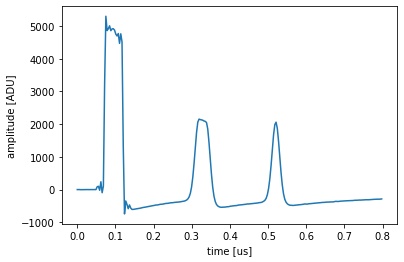

In [11]:
# use the regular readout in decimated mode to see the full pulse sequence

config['arming'] = 'none'
prog = ArmingProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc)

t = prog.get_time_axis(0)
plt.plot(t, iq_list[0][:,0])
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

  0%|          | 0/1 [00:00<?, ?it/s]

total tags: 3
tags per arming window: [3]
tags: [346504466 346505039 346505536]
total samples: 768


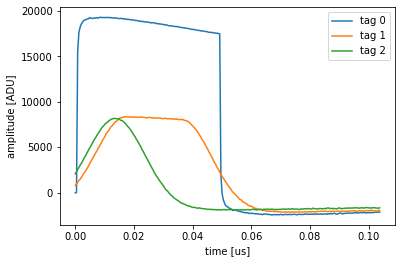

In [12]:
config['arming'] = 'none'
prog = ArmingProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

soc.qtt.clear_mems()
soc.qtt.arm()
iq_list = prog.acquire_decimated(soc)
soc.qtt.disarm()

plot_tags(NSAMP)

  0%|          | 0/1 [00:00<?, ?it/s]

total tags: 3
tags per arming window: [3]
tags: [2874 3447 3944]
total samples: 768


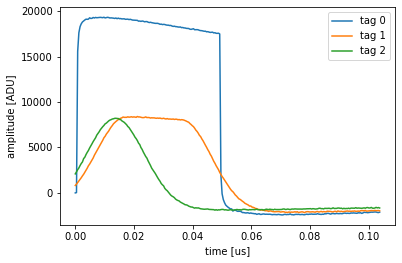

In [13]:
config['arming'] = 'peripheral'
prog = ArmingProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

soc.qtt.clear_mems()
iq_list = prog.acquire_decimated(soc)
plot_tags(NSAMP)

  0%|          | 0/1 [00:00<?, ?it/s]

total tags: 3
tags per arming window: [3]
tags: [2970 3543 4040]
total samples: 768


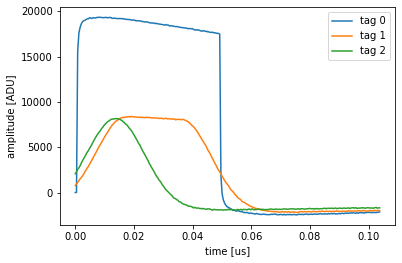

In [14]:
config['arming'] = 'trigger'
prog = ArmingProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

soc.qtt.clear_mems()
iq_list = prog.acquire_decimated(soc)
plot_tags(NSAMP)

### reading tags from the tProc
The time tagger has one more memory: this is a another queue for tags from channel 0, but is only readable by the tProc.
Here's a little program that flushes the contents of this queue into the tProc data memory.

In [15]:
# we want to be able to use run_rounds() to wait for this program to finish
# AcquireProgramV2 is the base class for programs that support run_rounds()
from qick.asm_v2 import AcquireProgramV2

def flush_tproc_tags(soc):
    prog = AcquireProgramV2(soccfg)
    prog.setup_counter(counter_addr=1, loop_dims=[1])
    
    # now let's write the program:
    prog.set_ext_counter(addr=1, val=0) # we'll set this to 1 at the end, so run_rounds() knows we're done
    prog.set_ext_counter(addr=2, val=0) # we'll use this (s_core_w2) to count how many tags we've popped

    prog.write_reg('s_cfg', 0x10_0004) # clear qpa_dt_new bit, wire s_core_r registers to peripheral
    prog.asm_inst({'CMD': 'PA', 'C_OP': '3', 'R1': 's0'}) # peek (update s_core_r2 with queue size)
    prog.asm_inst({'CMD': 'WAIT', 'C_OP': 'qpa_dt'}, addr_inc=2)
    
    # this is a while loop
    prog.label('LOOP')
    prog.cond_jump('DONE','s_core_r2', 'Z') # if tag queue is empty, break out of the loop
    prog.write_reg('s_cfg', 0x10_0004) # clear qpa_dt_new bit, wire s_core_r registers to peripheral
    prog.asm_inst({'CMD': 'PA', 'C_OP': '2', 'R1': 's0'}) # pop (move a tag from the queue into s_core_r1, update s_core_r2)
    prog.asm_inst({'CMD': 'WAIT', 'C_OP': 'qpa_dt'}, addr_inc=2)
    prog.write_dmem('s_core_w2', 's_core_r1') # copy the tag into the data memory
    prog.inc_ext_counter(addr=2, val=1)
    prog.jump('LOOP')
    
    prog.label('DONE')
    prog.inc_ext_counter(addr=1, val=1)
    prog.end()
    
    to_flush = soc.qtt.proc_qty # get the queue size from the time-tagger register
    print("tag queue for tproc:", to_flush)
    if to_flush:
        # just to be sure, zero the tProc data memory
        soc.tproc.load_mem(mem_sel='dmem', buff_in=np.zeros(to_flush, dtype=np.int32))
        soc.qtt.dma_cfg = soc.qtt.MEMS['TAG0'][0] # enable tProc access to the tag queue
        prog.run_rounds(soc)
        print(soc.tproc.read_mem(mem_sel='dmem', length=to_flush))
        print("loop counter:", soc.get_tproc_counter(2)) # this should match to_flush
flush_tproc_tags(soc)

tag queue for tproc: 9


  0%|          | 0/1 [00:00<?, ?it/s]

[346504466 346505039 346505536      2874      3447      3944      2970
      3543      4040]
loop counter: 9


Now let's write a program where we arm the time-tagger in each shot, and read the tags from each shot into the tProc.

In this toy program, we're copying the last tag from each shot into the tProc data memory.
In a real experiment, you might do some sort of feedback on the tag.

You can sweep the pulse time to show that the shot-by-shot tags make sense, or use a constant pulse time to see the (lack of) jitter.

In [16]:
class MultiArmProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch0 = cfg['gen_chs'][0]
        
        for gen_ch in cfg['gen_chs']:
            self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        
        self.add_pulse(ch=cfg['gen_chs'], name="myconst",
                       style="const", 
                       length=0.01,
                       freq=0, 
                       phase=0,
                       gain=1.0,
                      )
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=0)
#         self.write_reg('s_cfg', 4)

        # configure the regular readout
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)

    def _body(self, cfg):
        self.trigger(pins=[8], t=cfg['trig_time_tt'], width=cfg['ro_len'])
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time_ro'], ddr4=True)
        for gen_ch in cfg['gen_chs']:
            self.pulse(ch=gen_ch, name="myconst", t=cfg['pulse_time'])
            
        self.write_reg('s_cfg', 0x10_0004) # clear qpa_dt_new bit, wire s_core_r registers to peripheral
        self.wait(cfg['trig_time_tt']+cfg['ro_len'])

        self.asm_inst({'CMD': 'PA', 'C_OP': '3', 'R1': 's0'}) # peek (update s_core_r2 with queue size)
        self.asm_inst({'CMD': 'WAIT', 'C_OP': 'qpa_dt'}, addr_inc=2)

        # this is a while loop
        self.label('LOOP')
        self.cond_jump('DONE','s_core_r2', 'Z') # if tag queue is empty, break out of the loop
        self.write_reg('s_cfg', 0x10_0004) # clear qpa_dt_new bit, wire s_core_r registers to peripheral
        self.asm_inst({'CMD': 'PA', 'C_OP': '2', 'R1': 's0'}) # pop (move a tag from the queue into s_core_r1, update s_core_r2)
        self.asm_inst({'CMD': 'WAIT', 'C_OP': 'qpa_dt'}, addr_inc=2)
        self.write_dmem('reps', 's_core_r1') # copy the tag into the data memory
        self.jump('LOOP')
        self.label('DONE')

        self.resync(0.05)
            
config = {'gen_chs': [GEN_CH_TT, GEN_CH_REG],
          'ro_ch': RO_CH,
#           'pulse_time': 0.0,
          'pulse_time': QickSweep1D("reps", 0.0, 0.2),
          'ro_len': 0.5,
          'trig_time_ro': 0.4,
          'trig_time_tt': 0.1,
         }
NSAMP = 5 # units of ADC fabric clocks
soc.qtt.reset()
soc.qtt.set_config(filt=0, slope=0, interp=0, wr_smp=NSAMP, invert=0)
soc.qtt.set_dead_time(10) # units of ADC fabric clocks
soc.qtt.set_threshold(2000) # units of ADU, as measured by time-tagger

  0%|          | 0/10 [00:00<?, ?it/s]

total tags: 10
tags per arming window: [1 1 1 1 1 1 1 1 1 1]
tags: [266 314 362 410 458 506 554 602 650 698]
total samples: 400
tags from tproc: [266 314 362 410 458 506 554 602 650 698]


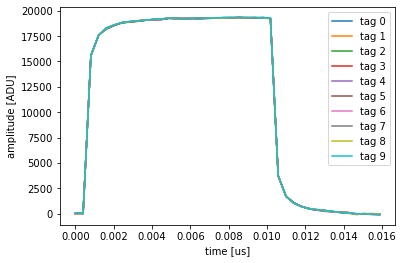

In [17]:
reps = 10
prog = MultiArmProgram(soccfg, reps=reps, final_delay=1.0, cfg=config)
soc.tproc.load_mem(mem_sel='dmem', buff_in=np.zeros(reps,dtype=np.int32))
soc.qtt.clear_mems()
# soc.qtt.read_mem('TAG0')
soc.qtt.dma_cfg = soc.qtt.MEMS['TAG0'][0]
iq_list = prog.acquire(soc)
plot_tags(NSAMP)
# print(prog.get_raw()[0][:,0,0])
print("tags from tproc:", soc.tproc.read_mem(mem_sel='dmem', length=reps))


In [18]:
# from qick.asm_v2 import QickProgramV2
# # use QickProgramV2 to write the same program using asm_inst
# lname = 'reps'
# prog = QickProgramV2(soccfg)
# prog.add_reg(lname)
# prog.write_reg(lname, 0)
# prog.label(lname)

# addr = prog.reg_dict[lname].full_addr()

# # prog.open_loop(10, 'reps')
# prog.write_dmem(lname, lname)

# # prog.asm_inst({'CMD':'REG_WR', 'DST':addr, 'SRC':'op', 'OP':f'{addr} - #1', 'UF':'1'})
# # prog.asm_inst({'CMD':'JUMP', 'LABEL':lname, 'IF':'NZ'})

# # prog.asm_inst({'CMD':'TEST', 'OP':f'{addr} - #9', 'UF':'1'})
# prog.asm_inst({'CMD':'TEST', 'OP':f'{addr} - #9'})

# # 'OP': 'r3 - #3', 'CMD': 'TEST'
# prog.asm_inst({'CMD':'JUMP', 'LABEL':lname, 'IF':'NZ', 'WR': 'r0 op', 'OP': 'r0 + #1'})

# # {'CMD': 'JUMP', 'LABEL': 'LOOP', 'IF': 'NZ', 'WR': 'r1 op', 'OP': 'r1 - #1'}
# prog.write_dmem(20, lname)

# # prog.close_loop()
# prog.end()

# soc.tproc.load_mem(mem_sel='dmem', buff_in=np.zeros(100,dtype=np.int32))
# prog.run(soc)
# print(soc.tproc.read_mem(mem_sel='dmem', length=100))

In [19]:
# soc.qtt.print_axi_regs()
# soc.qtt.reset()
# soc.qtt.qtt_ctrl = 0
# soc.qtt.qtt_ctrl = 15
# soc.qtt.print_axi_regs()


---------------------------------------------
--- AXI Registers
  qtt_ctrl           0 - 0000_0000_0000_0000_0000_0000_0000_0000
   qtt_cfg         160 - 0000_0000_0000_0000_0000_0000_1010_0000
   dma_cfg        6405 - 0000_0000_0000_0000_0001_1001_0000_0101
   axi_dt1        2000 - 0000_0000_0000_0000_0000_0111_1101_0000
   proc_dt         698 - 0000_0000_0000_0000_0000_0010_1011_1010
  proc_qty           0 - 0000_0000_0000_0000_0000_0000_0000_0000
  tag0_qty           0 - 0000_0000_0000_0000_0000_0000_0000_0000
  tag1_qty           0 - 0000_0000_0000_0000_0000_0000_0000_0000
  tag2_qty           0 - 0000_0000_0000_0000_0000_0000_0000_0000
  tag3_qty           0 - 0000_0000_0000_0000_0000_0000_0000_0000
   smp_qty           0 - 0000_0000_0000_0000_0000_0000_0000_0000
   arm_qty           0 - 0000_0000_0000_0000_0000_0000_0000_0000
   thr_inh      657360 - 0000_0000_0000_1010_0000_0111_1101_0000
qtt_status         359 - 0000_0000_0000_0000_0000_0001_0110_0111
 qtt_debug   402718720 - 0